In [1]:
import pandas as pd
# import seaborn as sns
import numpy as np
import scipy.sparse as ss
# import ruamel.yaml as yaml
import os
import yaml, inspect, os, sys, subprocess, pprint, shutil, argparse

import matplotlib.pyplot as plt
import re
from collections import defaultdict


In [2]:
def get_all_files_in_dir(given_dir):
    return sorted([
        os.path.join(
            given_dir,
            file 
        ) for file in os.listdir(given_dir) if 'yaml' in os.path.join(
            given_dir,
            file 
        )
    ])

In [3]:
eyerissv2_pe_config_file = os.path.join(
    os.getcwd(),
    '../evaluation_setups/fig12_eyerissv2_pe_setup/hardware-specs/configurations/SI-SW.yaml'
)
eyerissv2_pe_art_file = os.path.join(
    os.getcwd(),
    '../evaluation_setups/fig12_eyerissv2_pe_setup/ert_art/ART.yaml'
)
eyerissv2_pe_ert_file = os.path.join(
    os.getcwd(),
    '../evaluation_setups/fig12_eyerissv2_pe_setup/ert_art/ERT.yaml'
)
eyerissv2_pe_arch_file = os.path.join(
    os.getcwd(),
    '../evaluation_setups/fig12_eyerissv2_pe_setup/hardware-specs/designs/arch.yaml'
)
mobilenet_sparse_dir = os.path.join(
    os.getcwd(),
    '../evaluation_setups/fig12_eyerissv2_pe_setup/workload/mobilenet0.5-sparse/uniform'
#     '../evaluation_setups/fig12_eyerissv2_pe_setup/workload/mobilenet0.5-sparse/uniform_experiment'
)
mobilenet_sparse_mappings_dir = os.path.join(
    os.getcwd(),
    '../evaluation_setups/fig12_eyerissv2_pe_setup/mappings/mobilenet0.5-sparse/'
#     '../evaluation_setups/fig12_eyerissv2_pe_setup/mappings/mobilenet0.5-sparse-experiment/'
)

print(eyerissv2_pe_config_file,
eyerissv2_pe_art_file,
eyerissv2_pe_ert_file,
eyerissv2_pe_arch_file)

workload_file_array = get_all_files_in_dir(mobilenet_sparse_dir)
mapping_file_array = get_all_files_in_dir(mobilenet_sparse_mappings_dir)
# workload_dirs = [alexnet_conv_dir,spmspm_workloads_dir,mobilenet_sparse_dir]
# workload_dirs = [mobilenet_sparse_dir]
# mappings_dirs = [mobilenet_sparse_mappings_dir]



# for workload_dir in workload_dirs:
#     workload_file_array.extend([
#         os.path.join(
#             workload_dir,
#             file 
#         ) for file in os.listdir(workload_dir)
#     ])
    
# workload_file_array.sort()

# for mapping_dir in mappings_dirs:
#     mapping_file_array.extend([
#         os.path.join(
#             mapping_dir,
#             file 
#         ) for file in os.listdir(mapping_dir)
#     ])

# mapping_file_array.sort()

# print(workload_file_array)
# for workload in workload_file_array:
#     print(workload)

# for mapping in mapping_file_array:
#     print(mapping)

    
for workload,mapping in zip(workload_file_array,mapping_file_array):
    print(workload,mapping)
    print()

/home/workspace/2022.micro.artifact/notebook/../evaluation_setups/fig12_eyerissv2_pe_setup/hardware-specs/configurations/SI-SW.yaml /home/workspace/2022.micro.artifact/notebook/../evaluation_setups/fig12_eyerissv2_pe_setup/ert_art/ART.yaml /home/workspace/2022.micro.artifact/notebook/../evaluation_setups/fig12_eyerissv2_pe_setup/ert_art/ERT.yaml /home/workspace/2022.micro.artifact/notebook/../evaluation_setups/fig12_eyerissv2_pe_setup/hardware-specs/designs/arch.yaml
/home/workspace/2022.micro.artifact/notebook/../evaluation_setups/fig12_eyerissv2_pe_setup/workload/mobilenet0.5-sparse/uniform/L07.yaml /home/workspace/2022.micro.artifact/notebook/../evaluation_setups/fig12_eyerissv2_pe_setup/mappings/mobilenet0.5-sparse/L07-perfect_factor.yaml

/home/workspace/2022.micro.artifact/notebook/../evaluation_setups/fig12_eyerissv2_pe_setup/workload/mobilenet0.5-sparse/uniform/L09.yaml /home/workspace/2022.micro.artifact/notebook/../evaluation_setups/fig12_eyerissv2_pe_setup/mappings/mobilenet

In [4]:
# Energy breakdown 
def parse_energy_summary(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    algorithmic = {
        'total_computes': None,
        'total_energy_per_compute_pJ': None,
        'breakdown': {}
    }
    actual = {
        'total_computes': None,
        'total_energy_per_compute_pJ': None,
        'breakdown': {}
    }

    in_algo = False
    in_actual = False

    for line in lines:
        stripped = line.strip()

        # Header flags
        if stripped.startswith("Algorithmic Computes ="):
            algorithmic['total_computes'] = int(stripped.split('=')[1].strip())
            in_algo = True
            in_actual = False
            continue

        if stripped.startswith("Actual Computes ="):
            actual['total_computes'] = int(stripped.split('=')[1].strip())
            in_algo = False
            in_actual = True
            continue

        # Breakdown parsing
        if in_algo and re.match(r'^.+?=\s+[\d.]+$', stripped):
            key, val = map(str.strip, stripped.split(' = '))
            val = float(val)
            if val == 0:
                continue
            if key == "Total":
                algorithmic['total_energy_per_compute_pJ'] = val
            else:
                algorithmic['breakdown'][key] = val

        elif in_actual and re.match(r'^.+?=\s+[\d.]+$', stripped):
            key, val = map(str.strip, stripped.split(' = '))
            val = float(val)
            if val == 0:
                continue
            if key == "Total":
                actual['total_energy_per_compute_pJ'] = val
            else:
                actual['breakdown'][key] = val

    return algorithmic, actual




def plot_energy_breakdown_multiple(algorithmic_list, actual_list, labels):
    assert len(algorithmic_list) == len(actual_list) == len(labels), "Each algorithmic/actual entry must have a corresponding label."

    num_configs = len(algorithmic_list)

    # Gather all components used across all configs
    all_components = set()
    for entry in algorithmic_list + actual_list:
        all_components.update(entry['breakdown'].keys())
    components = sorted(all_components)

    # Prepare data matrix
    algo_data = []
    actual_data = []
    for alg, act in zip(algorithmic_list, actual_list):
        algo_data.append([alg['breakdown'].get(comp, 0.0) for comp in components])
        actual_data.append([act['breakdown'].get(comp, 0.0) for comp in components])

    # Transpose for stacking
    algo_data = list(zip(*algo_data))  # each sublist is a component across configs
    actual_data = list(zip(*actual_data))

    x = list(range(num_configs))
    width = 0.6

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10), sharey=True)

    # Algorithmic chart
    bottoms = [0] * num_configs
    for i, comp_vals in enumerate(algo_data):
        ax1.bar(x, comp_vals, width, bottom=bottoms, label=components[i], color=f"C{i}")
        bottoms = [bottoms[j] + comp_vals[j] for j in range(num_configs)]
    ax1.set_title("Algorithmic Energy Breakdown")
    ax1.set_ylabel("Energy per Compute (pJ)")
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, rotation=45)
    ax1.grid(axis='y', linestyle='--', alpha=0.6)

    # Actual chart
    bottoms = [0] * num_configs
    for i, comp_vals in enumerate(actual_data):
        ax2.bar(x, comp_vals, width, bottom=bottoms, label=components[i], color=f"C{i}")
        bottoms = [bottoms[j] + comp_vals[j] for j in range(num_configs)]
    ax2.set_title("Actual Energy Breakdown")
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels, rotation=45)
    ax2.grid(axis='y', linestyle='--', alpha=0.6)

    # Shared legend
    fig.legend(components, loc='center right', bbox_to_anchor=(1.12, 0.5))
    fig.tight_layout()
    plt.show()


In [5]:
# Average read/write bandwidth

def parse_bandwidth_stats(file_path):
    with open(file_path, 'r') as f:
        content = f.read()

    # Split the content by component sections
    components = re.split(r"=== (.+?) ===", content)[1:]  # [component_name, block, component_name, block, ...]

    bandwidth_data = {}

    for i in range(0, len(components), 2):
        comp_name = components[i].strip()
        comp_block = components[i+1]

        # Find the Average Read Bandwidth and Average Write Bandwidth blocks
        read_match = re.search(r"Average Read Bandwidth \(per-instance\).*?: ([\d.]+) words/cycle\s+Breakdown \(Data, Format\): \(([\d.]+)%, ([\d.]+)%\)", comp_block)
        write_match = re.search(r"Average Write Bandwidth \(per-instance\).*?: ([\d.]+) words/cycle\s+Breakdown \(Data, Format\): \(([\d.]+)%, ([\d.]+)%\)", comp_block)

        if read_match and write_match:
            read_bw, read_data_pct, read_format_pct = map(float, read_match.groups())
            write_bw, write_data_pct, write_format_pct = map(float, write_match.groups())

            bandwidth_data[comp_name] = {
                'read': {
                    'total': read_bw,
                    'data': read_bw * (read_data_pct / 100),
                    'format': read_bw * (read_format_pct / 100)
                },
                'write': {
                    'total': write_bw,
                    'data': write_bw * (write_data_pct / 100),
                    'format': write_bw * (write_format_pct / 100)
                }
            }

    return bandwidth_data


def plot_components_separately(bandwidth_data_list, labels=None):
    num_runs = len(bandwidth_data_list)
    components = list(bandwidth_data_list[0].keys())
    bar_width = 0.3

    for comp in components:
        read_data_vals = [bd[comp]['read']['data'] for bd in bandwidth_data_list]
        read_format_vals = [bd[comp]['read']['format'] for bd in bandwidth_data_list]
        write_data_vals = [bd[comp]['write']['data'] for bd in bandwidth_data_list]
        write_format_vals = [bd[comp]['write']['format'] for bd in bandwidth_data_list]

        x = np.arange(num_runs)

        fig, ax = plt.subplots(figsize=(12, 4))

        # Stack bars per run
        r1 = ax.bar(x, read_data_vals, bar_width, label='Read Data', color='tab:blue')
        r2 = ax.bar(x, read_format_vals, bar_width, bottom=read_data_vals, label='Read Format', color='lightblue')
        r3 = ax.bar(x, write_data_vals, bar_width, bottom=np.array(read_data_vals) + np.array(read_format_vals),
                    label='Write Data', color='tab:orange')
        r4 = ax.bar(x, write_format_vals, bar_width,
                    bottom=np.array(read_data_vals) + np.array(read_format_vals) + np.array(write_data_vals),
                    label='Write Format', color='moccasin')

        ax.set_ylabel('Bandwidth (words/cycle)')
        ax.set_title(f'Bandwidth Breakdown for Component: {comp}')
        ax.set_xticks(x)
        ax.set_xticklabels(labels if labels else [f'Run {i+1}' for i in x])
        ax.legend(loc='center right')
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()


In [6]:
# Scalar reads, writes and updates

def parse_scalar_activity(file_path):
    with open(file_path, 'r') as f:
        content = f.read()

    # Split the content by component sections
    components = re.split(r"=== (.+?) ===", content)[1:]  # [component_name, block, component_name, block, ...]

    scalar_activity = {}

    for i in range(0, len(components), 2):
        comp_name = components[i].strip()
        comp_block = components[i + 1]

        # Extract actual + skipped reads
        actual_reads = re.search(r"Actual scalar reads \(per-instance\)\s*:\s*(\d+)", comp_block)
        skipped_reads = re.search(r"Skipped scalar reads \(per-instance\)\s*:\s*(\d+)", comp_block)

        # Extract actual + skipped writes (fills)
        actual_writes = re.search(r"Actual scalar fills \(per-instance\)\s*:\s*(\d+)", comp_block)
        skipped_writes = re.search(r"Skipped scalar fills \(per-instance\)\s*:\s*(\d+)", comp_block)

        # Extract actual + skipped updates
        actual_updates = re.search(r"Actual scalar updates \(per-instance\)\s*:\s*(\d+)", comp_block)
        skipped_updates = re.search(r"Skipped scalar updates \(per-instance\)\s*:\s*(\d+)", comp_block)

        # Only include if at least one set is found
        if any([actual_reads, actual_writes, actual_updates]):
            scalar_activity[comp_name] = {
                "reads": {
                    "actual": int(actual_reads.group(1)) if actual_reads else 0,
                    "skipped": int(skipped_reads.group(1)) if skipped_reads else 0
                },
                "writes": {
                    "actual": int(actual_writes.group(1)) if actual_writes else 0,
                    "skipped": int(skipped_writes.group(1)) if skipped_writes else 0
                },
                "updates": {
                    "actual": int(actual_updates.group(1)) if actual_updates else 0,
                    "skipped": int(skipped_updates.group(1)) if skipped_updates else 0
                }
            }

    return scalar_activity

def plot_scalar_activity_multiple(scalar_stats_list, labels=None):
    num_runs = len(scalar_stats_list)
    components = list(scalar_stats_list[0].keys())
    num_components = len(components)
    x = np.arange(num_components)
    bar_width = 0.8 / num_runs

    def get_values(op):
        actual = []
        skipped = []
        for run in scalar_stats_list:
            actual.append([run[c][op]['actual'] for c in components])
            skipped.append([run[c][op]['skipped'] for c in components])
        return actual, skipped

    def plot_stacked_grouped(actual_list, skipped_list, title, ylabel):
        fig, ax = plt.subplots(figsize=(12, 5))
        for i in range(num_runs):
            offset = (i - num_runs / 2) * bar_width + bar_width / 2
            ax.bar(x + offset, actual_list[i], bar_width, label=f"{labels[i]} Actual" if labels else f"Run {i+1} Actual", color='tab:green')
            ax.bar(x + offset, skipped_list[i], bar_width, bottom=actual_list[i],
                   label=f"{labels[i]} Skipped" if labels else f"Run {i+1} Skipped", color='lightgreen')

        ax.set_xticks(x)
        ax.set_xticklabels(components, rotation=45, ha='right')
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    # Extract and plot each operation
    reads_actual, reads_skipped = get_values('reads')
    writes_actual, writes_skipped = get_values('writes')
    updates_actual, updates_skipped = get_values('updates')

    plot_stacked_grouped(reads_actual, reads_skipped, "Scalar Reads per Component", "Reads (per-instance)")
    plot_stacked_grouped(writes_actual, writes_skipped, "Scalar Writes (Fills) per Component", "Writes (per-instance)")
    plot_stacked_grouped(updates_actual, updates_skipped, "Scalar Updates per Component", "Updates (per-instance)")


In [7]:
def run_timeloop(workloads, mappings, config, pe_art, pe_ert, arch, output_dir):
    timeloop_exe = "timeloop-model"
    algorithmic_outputs_list = []
    actual_outputs_list = []
    bandwidth_list = []
    memory_movement_list = []
    labels = []
    for workload,mapping in zip(workloads,mappings):
        
        
        
        lst_of_input_files = [
            workload,
            mapping,
            config,
            pe_art,
            pe_ert,
            arch
        ]
        # print(lst_of_input_files)
        logfile_path = os.path.join(output_dir, f"timeloop_'{workload.split('/')[-1]}'.log")
        
        subprocess_cmd = [timeloop_exe, *lst_of_input_files]
       
        outfile = open(logfile_path, "w+")    
        status = subprocess.call(subprocess_cmd) 
        outfile.close()
        
        layer_name = workload.split("/")[-1]
        
        stat_file_name = f'./debug/timeloop-model_"{layer_name}".stats.txt'
        
        
        mv_cmd = ['mv','timeloop-model.stats.txt',stat_file_name]
        status = subprocess.call(mv_cmd) 
        
        algorithmic, actual = parse_energy_summary(stat_file_name)
        bandwidth_list.append((parse_bandwidth_stats(stat_file_name)))
        labels.append(layer_name)
        algorithmic_outputs_list.append(algorithmic)
        actual_outputs_list.append(actual)
        memory_movement_list.append(parse_scalar_activity(stat_file_name))
    
    plot_components_separately(bandwidth_list,labels)
    plot_energy_breakdown_multiple(algorithmic_outputs_list,actual_outputs_list,labels)
    plot_scalar_activity_multiple(memory_movement_list,labels)

Utilization = 1.00 | pJ/Algorithmic-Compute =    1.190 | pJ/Compute =    3.135


Utilization = 1.00 | pJ/Algorithmic-Compute =    1.792 | pJ/Compute =    2.540
Utilization = 1.00 | pJ/Algorithmic-Compute =    1.429 | pJ/Compute =    2.689


Utilization = 1.00 | pJ/Algorithmic-Compute =    1.028 | pJ/Compute =    3.064


Utilization = 1.00 | pJ/Algorithmic-Compute =    1.136 | pJ/Compute =    2.958


Utilization = 1.00 | pJ/Algorithmic-Compute =    1.248 | pJ/Compute =    2.922
Utilization = 1.00 | pJ/Algorithmic-Compute =    1.294 | pJ/Compute =    2.926
Utilization = 1.00 | pJ/Algorithmic-Compute =    0.658 | pJ/Compute =    3.783


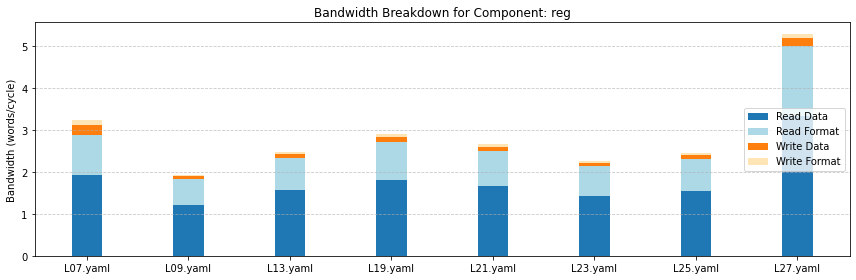

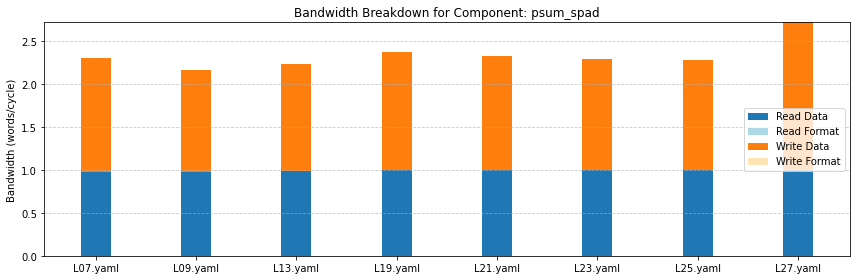

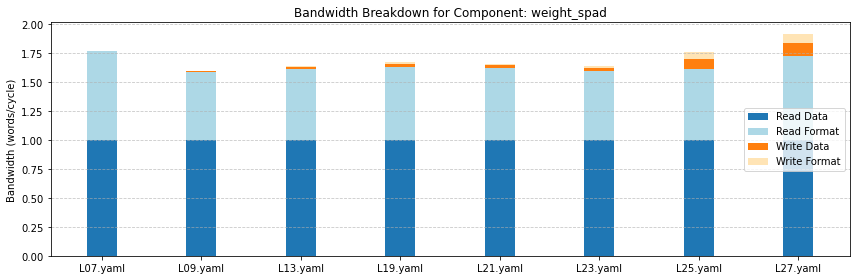

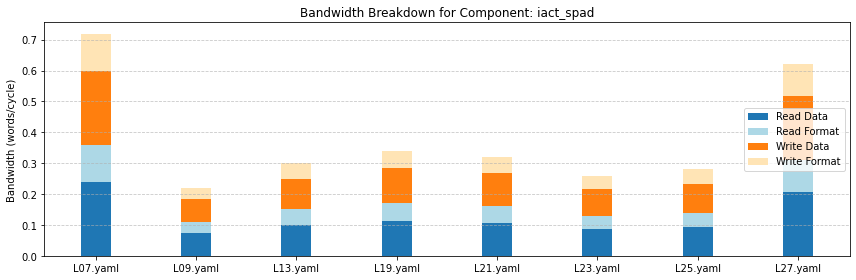

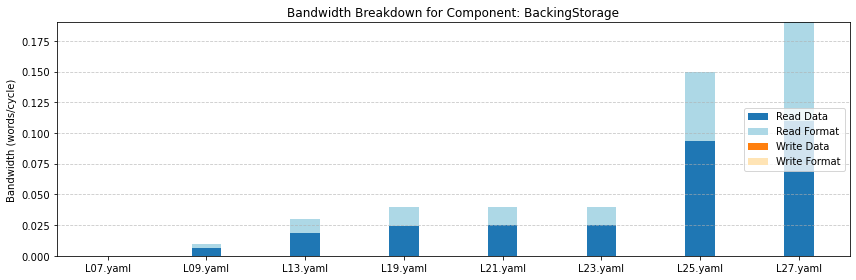

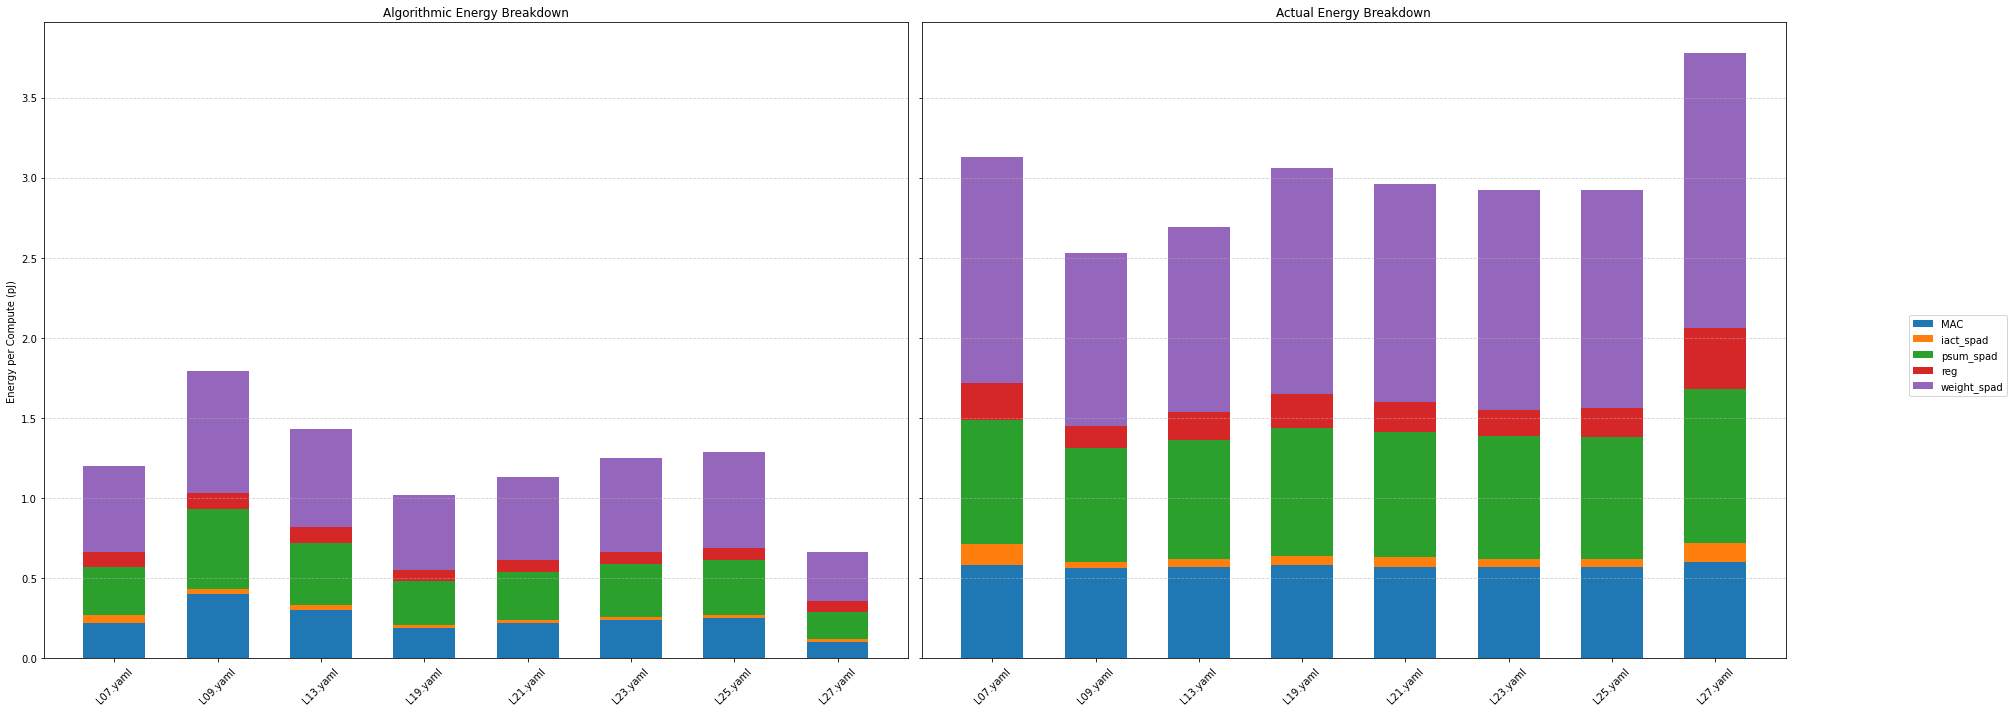

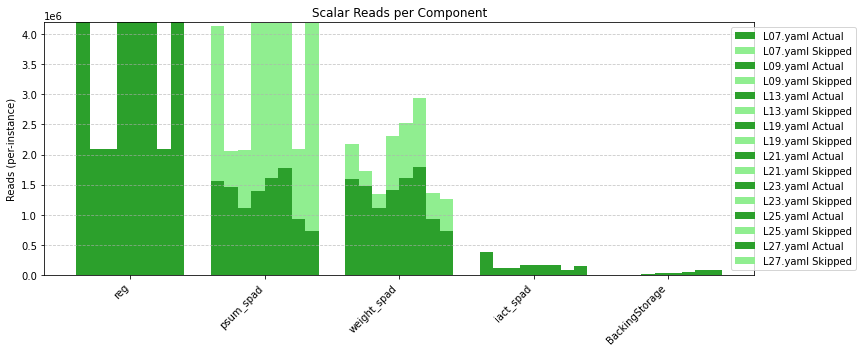

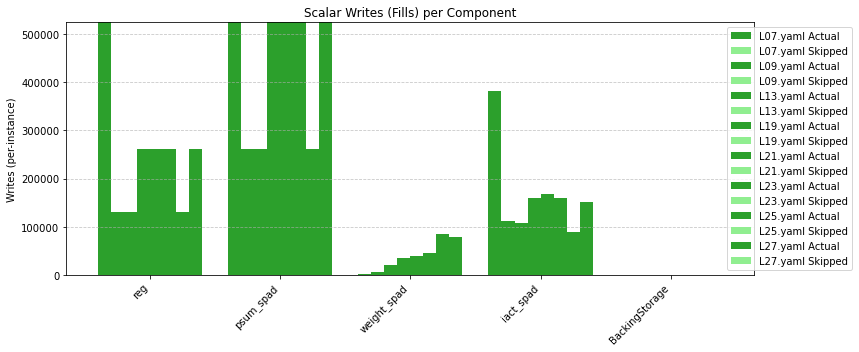

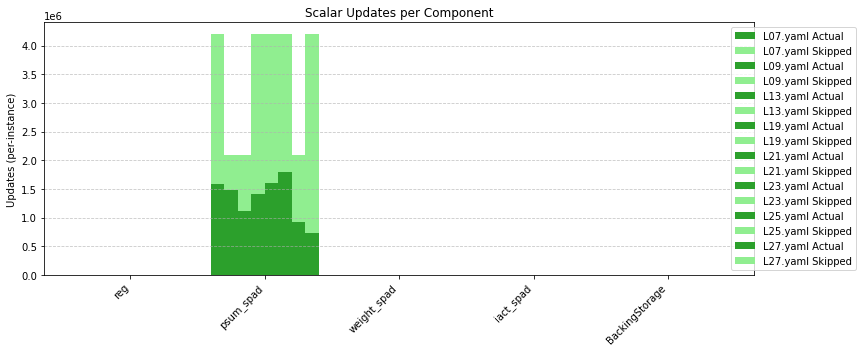

In [8]:
output_dir = os.path.join(os.getcwd(),'./debug')
run_timeloop(
    workload_file_array,
    mapping_file_array,
    eyerissv2_pe_config_file,
    eyerissv2_pe_art_file,
    eyerissv2_pe_ert_file,
    eyerissv2_pe_arch_file,
    output_dir)

In [9]:
mobilenet_sparse_dir = os.path.join(
    os.getcwd(),
#     '../evaluation_setups/fig12_eyerissv2_pe_setup/workload/mobilenet0.5-sparse/uniform'
    '../evaluation_setups/fig12_eyerissv2_pe_setup/workload/mobilenet0.5-sparse/uniform_experiment'
)
mobilenet_sparse_mappings_dir = os.path.join(
    os.getcwd(),
#     '../evaluation_setups/fig12_eyerissv2_pe_setup/mappings/mobilenet0.5-sparse/'
    '../evaluation_setups/fig12_eyerissv2_pe_setup/mappings/mobilenet0.5-sparse-experiment/'
)


workload_file_array = get_all_files_in_dir(mobilenet_sparse_dir) 
mapping_file_array = get_all_files_in_dir(mobilenet_sparse_mappings_dir) * len(workload_file_array)

for workload,mapping in zip(workload_file_array,mapping_file_array):
    print(workload,mapping)
    print()
    
    

/home/workspace/2022.micro.artifact/notebook/../evaluation_setups/fig12_eyerissv2_pe_setup/workload/mobilenet0.5-sparse/uniform_experiment/L07_sparse=0.1.yaml /home/workspace/2022.micro.artifact/notebook/../evaluation_setups/fig12_eyerissv2_pe_setup/mappings/mobilenet0.5-sparse-experiment/L07-perfect_factor.yaml

/home/workspace/2022.micro.artifact/notebook/../evaluation_setups/fig12_eyerissv2_pe_setup/workload/mobilenet0.5-sparse/uniform_experiment/L07_sparse=0.2.yaml /home/workspace/2022.micro.artifact/notebook/../evaluation_setups/fig12_eyerissv2_pe_setup/mappings/mobilenet0.5-sparse-experiment/L07-perfect_factor.yaml

/home/workspace/2022.micro.artifact/notebook/../evaluation_setups/fig12_eyerissv2_pe_setup/workload/mobilenet0.5-sparse/uniform_experiment/L07_sparse=0.3.yaml /home/workspace/2022.micro.artifact/notebook/../evaluation_setups/fig12_eyerissv2_pe_setup/mappings/mobilenet0.5-sparse-experiment/L07-perfect_factor.yaml

/home/workspace/2022.micro.artifact/notebook/../evaluat

Utilization = 1.00 | pJ/Algorithmic-Compute =    0.518 | pJ/Compute =    9.963
Utilization = 1.00 | pJ/Algorithmic-Compute =    0.625 | pJ/Compute =    6.007


Utilization = 1.00 | pJ/Algorithmic-Compute =    0.731 | pJ/Compute =    4.689
Utilization = 1.00 | pJ/Algorithmic-Compute =    0.838 | pJ/Compute =    4.029
Utilization = 1.00 | pJ/Algorithmic-Compute =    0.945 | pJ/Compute =    3.634


Utilization = 1.00 | pJ/Algorithmic-Compute =    1.052 | pJ/Compute =    3.370
Utilization = 1.00 | pJ/Algorithmic-Compute =    1.158 | pJ/Compute =    3.182


Utilization = 1.00 | pJ/Algorithmic-Compute =    1.265 | pJ/Compute =    3.040
Utilization = 1.00 | pJ/Algorithmic-Compute =    1.372 | pJ/Compute =    2.930


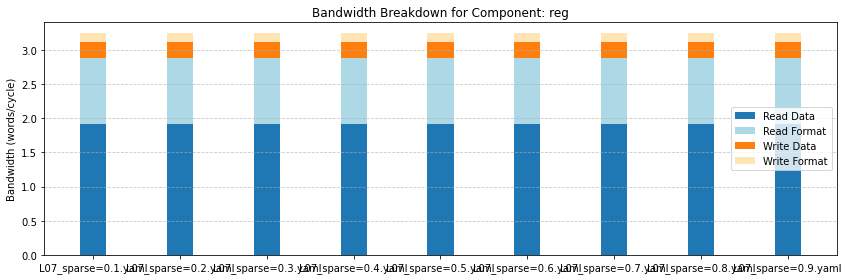

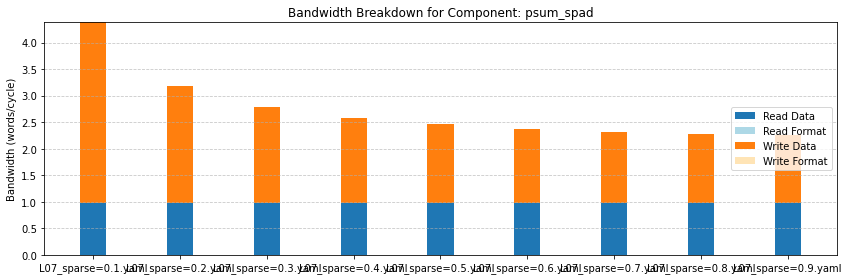

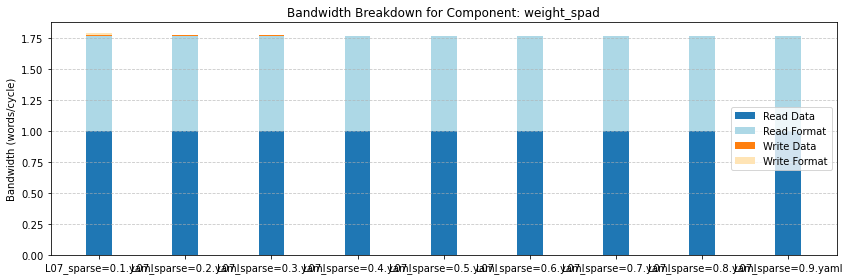

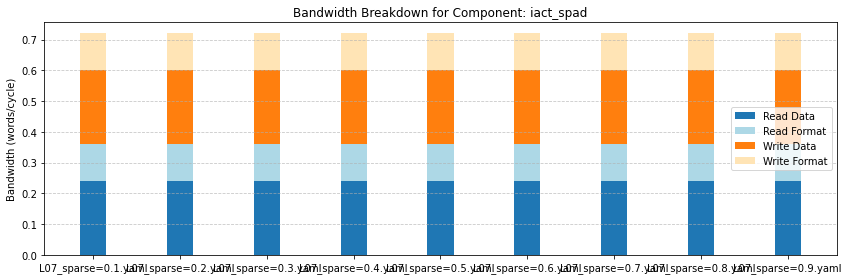

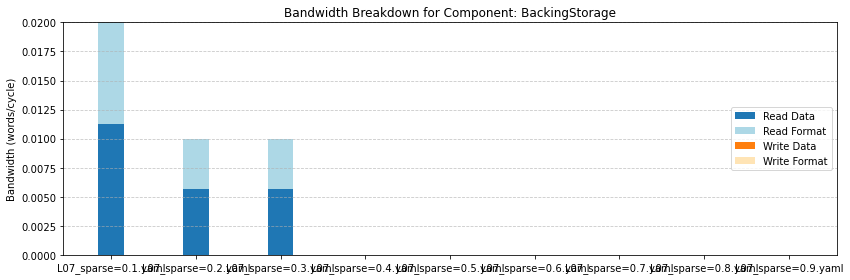

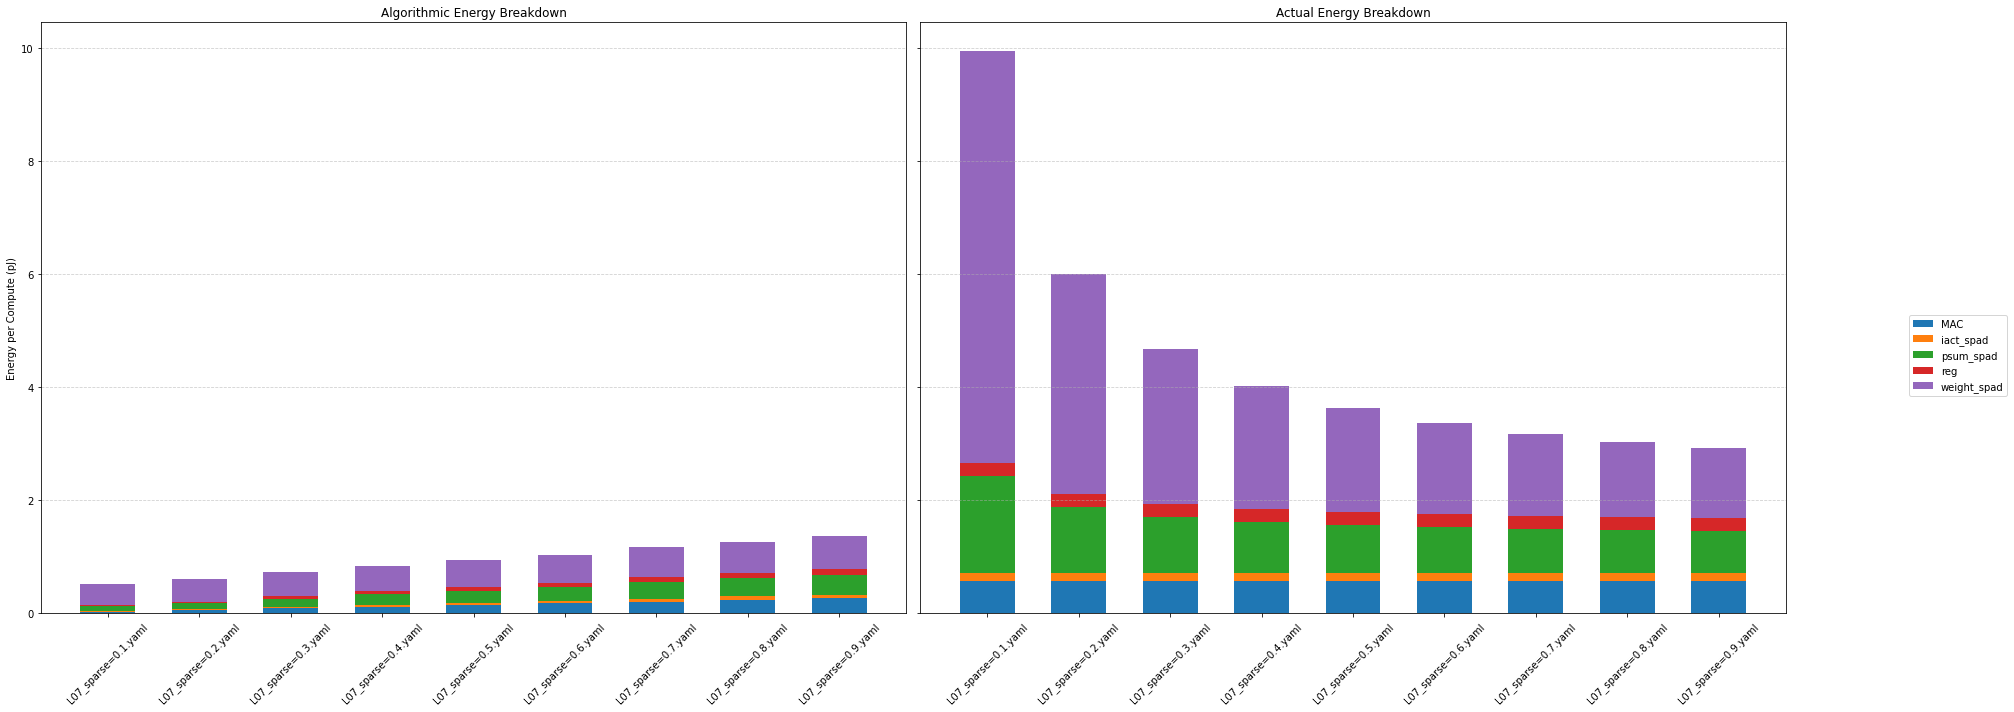

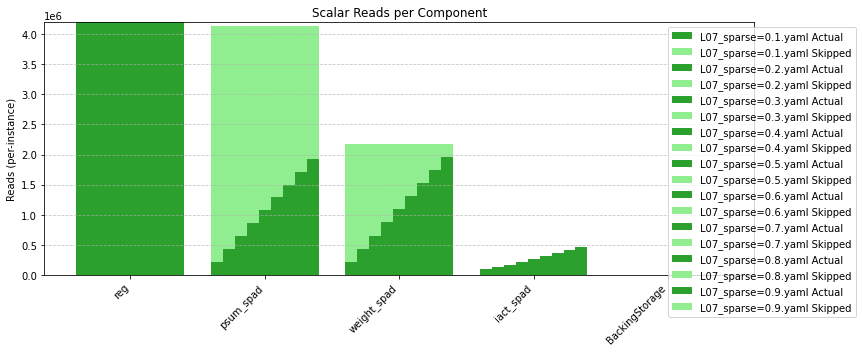

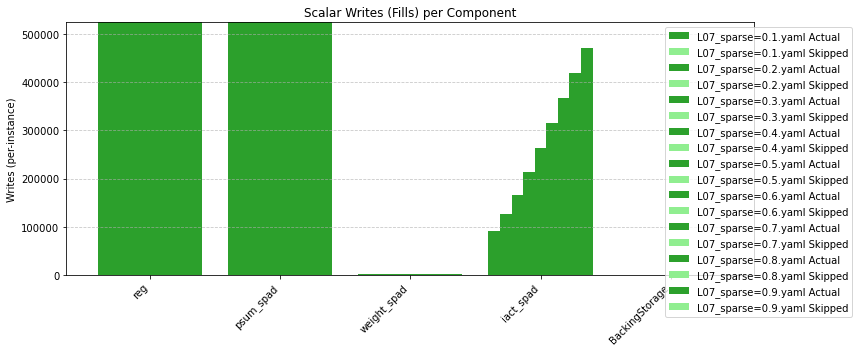

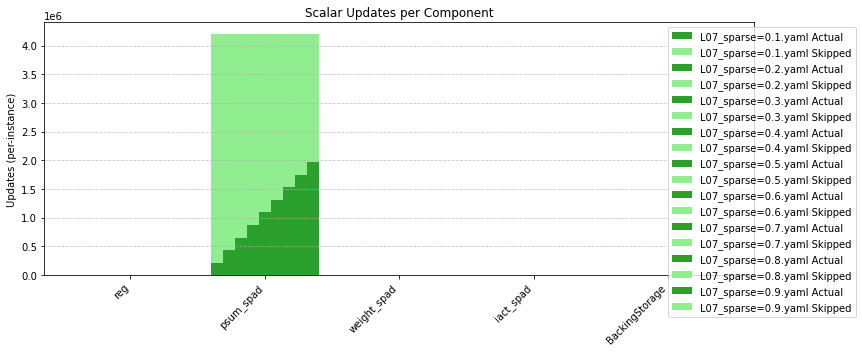

In [10]:
output_dir = os.path.join(os.getcwd(),'./debug')
run_timeloop(
    workload_file_array,
    mapping_file_array,
    eyerissv2_pe_config_file,
    eyerissv2_pe_art_file,
    eyerissv2_pe_ert_file,
    eyerissv2_pe_arch_file,
    output_dir)